<a href="https://colab.research.google.com/github/mrbenbot/wimblepong/blob/main/Wimblepong_Reinforcement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Step 1: Setup Google Colab Environment
%pip install gym
%pip install stable-baselines3[extra]
%pip install imageio pillow
%pip install tensorflowjs




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 14.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [92]:
# Import necessary libraries
import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.registration import register

import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, VecCheckNan
from stable_baselines3.common.monitor import Monitor


from IPython import display

import os
import imageio
import glob
import math

from IPython.display import display, Image, HTML

import tensorflow as tf
from tensorflow.keras import layers
import torch as th
import numpy as np

import matplotlib.pyplot as plt

from moviepy.editor import ImageSequenceClip
import pygame


# Check versions
print("gym version:", gym.__version__)
print("stable-baselines3 version:", stable_baselines3.__version__)


gym version: 0.29.1
stable-baselines3 version: 2.3.2


In [5]:
COURT_HEIGHT = 800
COURT_WIDTH = 1200
PADDLE_HEIGHT = 90
PADDLE_WIDTH = 15
BALL_RADIUS = 12
INITIAL_BALL_SPEED = 10
PADDLE_SPEED_DIVISOR = 15  # Example value, adjust as needed
PADDLE_CONTACT_SPEED_BOOST_DIVISOR = 4  # Example value, adjust as needed
SPEED_INCREMENT = 0.6  # Example value, adjust as needed
SERVING_HEIGHT_MULTIPLIER = 2  # Example value, adjust as needed
PLAYER_COLOURS = {'Player1': 'blue', 'Player2': 'red'}
MAX_COMPUTER_PADDLE_SPEED = 10

In [6]:
rewards_map = {
    "hit_paddle": lambda _: 50,
    "score_point": lambda _: 100,
    "conceed_point": lambda ball, paddle, rally_length: (-abs(ball['y'] - paddle['y']) / max(rally_length, 1))/100,
    # "conceed_point": lambda ball, paddle, rally_length: -0.1,
    "serve": lambda ball_speed: ball_speed / 10,
    "paddle_movement": lambda dy: 0,
    "ball_distance": lambda ball, paddle: 0
}

In [106]:



class Player:
    Player1 = 'Player1'
    Player2 = 'Player2'

class PlayerPositions:
    Initial = 'Initial'
    Reversed = 'Reversed'

class GameEventType:
    ResetBall = 'ResetBall'
    Serve = 'Serve'
    WallContact = 'WallContact'
    HitPaddle = 'HitPaddle'
    ScorePointLeft = 'ScorePointLeft'
    ScorePointRight = 'ScorePointRight'

def get_bounce_angle(paddle_y, paddle_height, ball_y):
    relative_intersect_y = (paddle_y + (paddle_height / 2)) - ball_y
    normalized_relative_intersect_y = relative_intersect_y / (paddle_height / 2)
    return normalized_relative_intersect_y * (math.pi / 4)

class CustomPongEnv(gym.Env):
    def __init__(self):
        super(CustomPongEnv, self).__init__()

        self.action_space = spaces.Box(low=np.array([0, -60]), high=np.array([1, 60]), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=np.array([0, 0, -np.inf, -np.inf, 0, 0, 0, 0], dtype=np.float32),
            high=np.array([COURT_WIDTH, COURT_HEIGHT, np.inf, np.inf, COURT_WIDTH, COURT_HEIGHT, 1, 1], dtype=np.float32)
        )
        self.starting_states = [
           {'server': Player.Player1, 'positions_reversed': False, 'opponent': Player.Player1, 'player': Player.Player2},
           {'server': Player.Player2, 'positions_reversed': True, 'opponent': Player.Player1, 'player': Player.Player2},
           {'server': Player.Player1, 'positions_reversed': True, 'opponent': Player.Player1, 'player': Player.Player2},
           {'server': Player.Player2, 'positions_reversed': False, 'opponent': Player.Player1, 'player': Player.Player2},
        ]

        self.starting_state_index = 0
        self.serve_delay = 50
        self.serve_delay_counter = 0
        self.direction = 15

        self.screen = None
        self.frame_count = 0
        self.last_event = None

        self.is_done = False
        self.reset(seed=0)

    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]

    def reset(self, seed=None):
        super().reset(seed=seed)
        if seed is not None:
            self.seed(seed)
        # print("Environment reset")
        starting_state = self.starting_states[self.starting_state_index]
        self.starting_state_index = (self.starting_state_index + 1) % len(self.starting_states)

        server = starting_state['server']
        positions_reversed = starting_state['positions_reversed']
        computer = starting_state['opponent']
        player = starting_state['player']

        self.game_state = {
            'server': server,
            'positions_reversed': positions_reversed,
            'opponent': computer,
            'player': player,
            Player.Player1: {'x': 0, 'y': COURT_HEIGHT // 2 - PADDLE_HEIGHT // 2, 'dy': 0, 'width': PADDLE_WIDTH, 'height': PADDLE_HEIGHT, 'colour': 'blue'},
            Player.Player2: {'x': COURT_WIDTH - PADDLE_WIDTH, 'y': COURT_HEIGHT // 2 - PADDLE_HEIGHT // 2, 'dy': 0, 'width': PADDLE_WIDTH, 'height': PADDLE_HEIGHT, 'colour': 'red'},
            'ball': {'x': COURT_WIDTH // 2, 'y': COURT_HEIGHT // 2, 'dx': INITIAL_BALL_SPEED, 'dy': INITIAL_BALL_SPEED, 'radius': BALL_RADIUS, 'speed': INITIAL_BALL_SPEED, 'serve_mode': True, 'score_mode': False, 'score_mode_timeout': 0},
            'stats': {'rally_length': 0, 'serve_speed': INITIAL_BALL_SPEED, 'server': server}
        }
        self.apply_meta_game_state()
        self.serve_delay_counter = 0
        self.direction = 30 * np.random.rand()
        self.serve_delay = 100 * np.random.rand()
        self.direction = self.direction if np.random.rand() > 0.5 else -self.direction

        self.step_count = 0

        self.is_done = False
        return self._get_obs(), {}

    def apply_meta_game_state(self):
        game_state = self.game_state
        serving_player = game_state['server']
        positions_reversed = game_state['positions_reversed']
        if serving_player == Player.Player1:
            self.game_state[Player.Player1]['height'] = PADDLE_HEIGHT * SERVING_HEIGHT_MULTIPLIER
            self.game_state[Player.Player2]['height'] = PADDLE_HEIGHT
        else:
            self.game_state[Player.Player1]['height'] = PADDLE_HEIGHT
            self.game_state[Player.Player2]['height'] = PADDLE_HEIGHT * SERVING_HEIGHT_MULTIPLIER
        if positions_reversed:
            self.game_state[Player.Player1]['x'] = COURT_WIDTH - PADDLE_WIDTH
            self.game_state[Player.Player2]['x'] = 0
        else:
            self.game_state[Player.Player1]['x'] = 0
            self.game_state[Player.Player2]['x'] = COURT_WIDTH - PADDLE_WIDTH
        ball = self.game_state['ball']
        server_is_left = (serving_player == Player.Player1 and not positions_reversed) or (serving_player == Player.Player2 and positions_reversed)
        ball['y'] = self.game_state[serving_player]['height'] / 2 + self.game_state[serving_player]['y']
        ball['x'] = self.game_state[serving_player]['width'] + ball['radius'] if server_is_left else COURT_WIDTH - self.game_state[serving_player]['width'] - ball['radius']
        ball['speed'] = INITIAL_BALL_SPEED
        ball['serve_mode'] = True
        ball['score_mode'] = False
        ball['score_mode_timeout'] = 0
        self.game_state['stats']['rally_length'] = 0

    def step(self, action):
        # print(f"Action taken: {action}")
        self.step_count += 1
        button_pressed = action[0] > 0.5
        paddle_direction = action[1]
        model_player_actions = {'button_pressed': button_pressed, 'paddle_direction': paddle_direction}
        computer_player_actions = self.get_computer_player_actions(self.game_state['opponent'])
        actions = {self.game_state['opponent']: computer_player_actions, self.game_state['player']: model_player_actions}
        reward = self.update_game_state(actions, 2.5)
        obs = self._get_obs()
        info = {}
        terminated = self.check_done()
        truncated = False
        return obs, reward, terminated, truncated, info

    def update_game_state(self, actions, delta_time):
        reward = 0
        game_state = self.game_state
        ball = game_state['ball']
        stats = game_state['stats']
        server = game_state['server']
        paddle_left, paddle_right = (game_state[Player.Player2], game_state[Player.Player1]) if game_state['positions_reversed'] else (game_state[Player.Player1], game_state[Player.Player2])
        model_is_left = (game_state['player'] == Player.Player1 and not game_state['positions_reversed']) or (game_state['player'] == Player.Player2 and game_state['positions_reversed'])
        if ball['score_mode']:
            self.is_done = True
            return 0.01
        elif ball['serve_mode']:
            serving_from_left = (server == Player.Player1 and not game_state['positions_reversed']) or (server == Player.Player2 and game_state['positions_reversed'])
            if serving_from_left:
                ball['x'] = game_state[server]['width'] + ball['radius']
            else:
                ball['x'] = COURT_WIDTH - game_state[server]['width'] - ball['radius']
            if actions[server]['button_pressed']:
                ball['speed'] = INITIAL_BALL_SPEED
                ball['dx'] = INITIAL_BALL_SPEED if serving_from_left else -INITIAL_BALL_SPEED
                ball['serve_mode'] = False
                stats['rally_length'] += 1
                stats['serve_speed'] = abs(ball['dy']) + abs(ball['dx'])
                stats['server'] = server
                if game_state['player'] == server:
                    reward += rewards_map['serve'](abs(ball['dy']) + abs(ball['dx']))
            ball['dy'] = (game_state[server]['y'] + game_state[server]['height'] / 2 - ball['y']) / PADDLE_SPEED_DIVISOR
            ball['y'] += ball['dy'] * delta_time
        else:
            ball['x'] += ball['dx'] * delta_time
            ball['y'] += ball['dy'] * delta_time
            if ball['y'] - ball['radius'] < 0:
                ball['dy'] = -ball['dy']
                ball['y'] = ball['radius']
            elif ball['y'] + ball['radius'] > COURT_HEIGHT:
                ball['dy'] = -ball['dy']
                ball['y'] = COURT_HEIGHT - ball['radius']
            if ball['x'] - ball['radius'] < paddle_left['x'] + paddle_left['width'] and ball['y'] + ball['radius'] > paddle_left['y'] and ball['y'] - ball['radius'] < paddle_left['y'] + paddle_left['height']:
                bounce_angle = get_bounce_angle(paddle_left['y'], paddle_left['height'], ball['y'])
                ball['dx'] = (ball['speed'] + abs(paddle_left['dy']) / PADDLE_CONTACT_SPEED_BOOST_DIVISOR) * math.cos(bounce_angle)
                ball['dy'] = (ball['speed'] + abs(paddle_left['dy']) / PADDLE_CONTACT_SPEED_BOOST_DIVISOR) * -math.sin(bounce_angle)
                ball['x'] = paddle_left['x'] + paddle_left['width'] + ball['radius']
                ball['speed'] += SPEED_INCREMENT
                stats['rally_length'] += 1
                if paddle_left == game_state['player']:
                    reward += rewards_map["hit_paddle"](stats['rally_length'])
            elif ball['x'] + ball['radius'] > paddle_right['x'] and ball['y'] + ball['radius'] > paddle_right['y'] and ball['y'] - ball['radius'] < paddle_right['y'] + paddle_right['height']:
                bounce_angle = get_bounce_angle(paddle_right['y'], paddle_right['height'], ball['y'])
                ball['dx'] = -(ball['speed'] + abs(paddle_right['dy']) / PADDLE_CONTACT_SPEED_BOOST_DIVISOR) * math.cos(bounce_angle)
                ball['dy'] = (ball['speed'] + abs(paddle_right['dy']) / PADDLE_CONTACT_SPEED_BOOST_DIVISOR) * -math.sin(bounce_angle)
                ball['x'] = paddle_right['x'] - ball['radius']
                ball['speed'] += SPEED_INCREMENT
                stats['rally_length'] += 1
                if paddle_right == game_state['player']:
                    reward += rewards_map["hit_paddle"](stats['rally_length'])
            if ball['x'] - ball['radius'] < 0:
                ball['score_mode'] = True
                if model_is_left:
                    reward += rewards_map['conceed_point'](ball, paddle_left, stats['rally_length'])
                else:
                    reward += rewards_map['score_point'](stats['rally_length'])
            elif ball['x'] + ball['radius'] > COURT_WIDTH:
                ball['score_mode'] = True
                if not model_is_left:
                    reward += rewards_map['conceed_point'](ball, paddle_right, stats['rally_length'])
                else:
                    reward += rewards_map['score_point'](stats['rally_length'])
        if game_state['positions_reversed']:
            game_state[Player.Player1]['dy'] = actions[Player.Player1]['paddle_direction']
            game_state[Player.Player2]['dy'] = -actions[Player.Player2]['paddle_direction']
        else:
            game_state[Player.Player1]['dy'] = -actions[Player.Player1]['paddle_direction']
            game_state[Player.Player2]['dy'] = actions[Player.Player2]['paddle_direction']
        game_state[Player.Player1]['y'] += game_state[Player.Player1]['dy'] * delta_time
        game_state[Player.Player2]['y'] += game_state[Player.Player2]['dy'] * delta_time
        if model_is_left:
            reward += rewards_map['paddle_movement'](abs(paddle_left['dy']))
        else:
            reward += rewards_map['paddle_movement'](abs(paddle_right['dy']))
        if paddle_left['y'] < 0:
            paddle_left['y'] = 0
        if paddle_left['y'] + paddle_left['height'] > COURT_HEIGHT:
            paddle_left['y'] = COURT_HEIGHT - paddle_left['height']
        if paddle_right['y'] < 0:
            paddle_right['y'] = 0
        if paddle_right['y'] + paddle_right['height'] > COURT_HEIGHT:
            paddle_right['y'] = COURT_HEIGHT - paddle_right['height']
        reward += 0.01 * stats['rally_length']
        return reward

    def get_computer_player_actions(self, player):
        state = self.game_state
        is_left = (player == Player.Player1 and not state['positions_reversed']) or (player == Player.Player2 and state['positions_reversed'])
        if state['ball']['score_mode']:
            return {'button_pressed': False, 'paddle_direction': 0}
        paddle = state[player]
        if state['ball']['serve_mode']:
            if paddle['y'] <= 0 or paddle['y'] + paddle['height'] >= COURT_HEIGHT:
                self.direction = -self.direction
            if self.serve_delay_counter > self.serve_delay:
                return {'button_pressed': True, 'paddle_direction': self.direction}
            else:
                self.serve_delay_counter += 1
                return {'button_pressed': False, 'paddle_direction': self.direction}
        if is_left:
            return {
                'button_pressed': False,
                'paddle_direction': self.bounded_value(
                    paddle['y'] - state['ball']['y'] + paddle['height'] / 4,
                    -MAX_COMPUTER_PADDLE_SPEED,
                    MAX_COMPUTER_PADDLE_SPEED
                )
            }
        else:
            return {
                'button_pressed': False,
                'paddle_direction': -self.bounded_value(
                    paddle['y'] - state['ball']['y'] + paddle['height'] / 4 ,
                    -MAX_COMPUTER_PADDLE_SPEED,
                    MAX_COMPUTER_PADDLE_SPEED
                )
            }

    def bounded_value(self, value, min_value, max_value):
        return max(min_value, min(max_value, value))

    def _get_obs(self):
        state = self.game_state
        player = state['player']
        is_server = 1 if self.game_state['server'] == player else 0
        paddle = state[player]
        obs = np.array([
            float(state['ball']['x']),
            float(state['ball']['y']),
            float(state['ball']['dx']),
            float(state['ball']['dy']),
            float(paddle['x']),
            float(paddle['y']),
            float(int(state['ball']['serve_mode'])),
            float(is_server),
        ], dtype=np.float32)
        return obs

    def check_done(self):
        if self.game_state['stats']['rally_length'] > 100:
            return True
        if self.step_count > 1000:
            return True
        return self.is_done

    def render(self, mode='human', close=False):
        if close:
            if pygame.get_init():
                pygame.quit()
            return

        if self.screen is None:
            pygame.init()
            self.screen = pygame.display.set_mode((COURT_WIDTH, COURT_HEIGHT))
        if not os.path.exists('./frames'):
            os.makedirs("./frames")

        # Clear screen
        self.screen.fill((255, 255, 255))  # Fill with white background
        state = self.game_state
        # Render paddles
        paddle1 = state[Player.Player1]
        paddle2 = state[Player.Player2]
        pygame.draw.rect(self.screen, paddle1['colour'], (paddle1['x'], paddle1['y'], paddle1['width'], paddle1['height']))
        pygame.draw.rect(self.screen, paddle2['colour'], (paddle2['x'], paddle2['y'], paddle2['width'], paddle2['height']))

        # Render ball
        ball = state['ball']
        pygame.draw.circle(self.screen, (0, 0, 0), (ball['x'], ball['y']), ball['radius'])

        # Update the display
        pygame.display.flip()

        # Save frame as image
        frame_path = f'./frames/frame_{self.frame_count:04d}.png'
        pygame.image.save(self.screen, frame_path)
        self.frame_count += 1


    def close(self):
        if not os.path.exists('./frames'):
            print("No frames directory found, skipping video creation.")
            return
        image_files = [f"./frames/frame_{i:04d}.png" for i in range(self.frame_count)]

        # Create a video clip from the image sequence
        clip = ImageSequenceClip(image_files, fps=24)  # 24 frames per second

        # Write the video file
        clip.write_videofile("./game_video.mp4", codec="libx264")
        pygame.quit()
        frames_dir = "./frames"
        if os.path.exists(frames_dir):
            for filename in os.listdir(frames_dir):
                file_path = os.path.join(frames_dir, filename)
                if os.path.isfile(file_path):
                    os.unlink(file_path)
            os.rmdir(frames_dir)


register(
    id='CustomPongEnv-v0',
    entry_point='__main__:CustomPongEnv',  # This entry point should match your custom environment class
)


  logger.warn(f"Overriding environment {new_spec.id} already in registry.")



In [38]:
# Create and test vectorised environment
# Create a vectorized environment
env = DummyVecEnv([lambda: gym.make('CustomPongEnv-v0') for _ in range(1)])  # Adjust number of instances as needed
env = VecNormalize(env, norm_obs=True, norm_reward=True)  # Normalize observations and rewards
# env = VecCheckNan(env, raise_exception=True)  # Wrap with VecCheckNan to detect NaNs


obs = env.reset()
print("Initial observation:", obs)

for i in range(10000000):
    action = env.action_space.sample()  # Sample random action
    print("Action taken:", action)
    obs, reward, done, info = env.step([action for _ in range(1)])
    print("Observation:", obs)
    print("Reward:", reward)
    print('iteration:', i)
    print("Done:", done)
    if np.any(done):
        obs = env.reset()
        break
        print("Environment reset")

env.close()

Environment reset
Environment reset
Initial observation: [[0.00999315 0.00999997 0.00995036 0.00995036 0.         0.00999996
  0.00707071 0.00707071]]
Action taken: [ 0.14008403 51.690395  ]
Action taken: [ 0.14008403 51.690395  ]
Observation: [[ 0.00706622  0.00707105  0.00703597 -0.999949    0.         -0.99929583
   0.00499969  0.00499969]]
Reward: [0.]
iteration: 0
Done: [False]
Action taken: [ 0.7669443 -4.942801 ]
Action taken: [ 0.7669443 -4.942801 ]
Observation: [[ 0.00576955 -1.3709505   0.00574484 -1.1932889   0.         -0.59796655
  -1.4140368   0.00408214]]
Reward: [1.9998039]
iteration: 1
Done: [False]
Action taken: [  0.91694933 -44.478245  ]
Action taken: [  0.91694933 -44.478245  ]
Observation: [[ 1.7319448  -1.4962285   0.00497518 -0.8874667   0.          0.9496263
  -0.99992496  0.00353516]]
Reward: [0.02100232]
iteration: 2
Done: [False]
Action taken: [  0.675326 -34.00926 ]
Action taken: [  0.675326 -34.00926 ]
Observation: [[ 1.7499822  -1.5388896   0.00444993 -0.

In [69]:

# Create and test single environment
env = Monitor(CustomPongEnv())

obs = env.reset()
print("Initial observation:", obs)

for i in range(1000):
    action = env.action_space.sample()  # Sample random action
    obs, reward, done, info, _ = env.step(action)
    print("Action taken:", action)
    print("Observation:", obs)
    print("Reward:", reward)
    print('iteration:', i)
    print("Done:", done)
    env.render()
    if done:
        obs = env.reset()
        print("Environment reset")
        break

env.close()

Initial observation: (array([ 27., 445.,  10.,  10.,   0., 355.,   1.,   1.], dtype=float32), {})
Action taken: [  0.66004217 -12.0962925 ]
Observation: [ 27.      445.       10.        0.        0.      385.24072   0.
   1.     ]
Reward: 2.01
iteration: 0
Done: False
Action taken: [ 0.6016889 32.372963 ]
Observation: [ 52.      445.       10.        0.        0.      304.30832   0.
   1.     ]
Reward: 0.01
iteration: 1
Done: False
Action taken: [  0.17336531 -56.311985  ]
Observation: [ 77.     445.      10.       0.       0.     445.0883   0.       1.    ]
Reward: 0.01
iteration: 2
Done: False
Action taken: [ 0.19099507 59.82043   ]
Observation: [102.     445.      10.       0.       0.     295.5372   0.       1.    ]
Reward: 0.01
iteration: 3
Done: False
Action taken: [  0.2484102 -16.875475 ]
Observation: [127.     445.      10.       0.       0.     337.7259   0.       1.    ]
Reward: 0.01
iteration: 4
Done: False
Action taken: [  0.30493116 -20.778341  ]
Observation: [152.      4

  size = imread(sequence[0]).shape



Action taken: [ 0.14228591 20.377926  ]
Observation: [ 18.840725  388.30756    -7.5682573 -11.419785    0.         43.48055
   0.          1.       ]
Reward: 0.04
iteration: 179
Done: False
Action taken: [0.43817136 5.5411897 ]
Observation: [-7.9919219e-02  3.5975809e+02 -7.5682573e+00 -1.1419785e+01
  0.0000000e+00  2.9627575e+01  0.0000000e+00  1.0000000e+00]
Reward: -0.7506938320819745
iteration: 180
Done: False
Action taken: [ 0.33756116 17.187254  ]
Observation: [-7.9919219e-02  3.5975809e+02 -7.5682573e+00 -1.1419785e+01
  0.0000000e+00  2.9627575e+01  0.0000000e+00  1.0000000e+00]
Reward: 0.01
iteration: 181
Done: True
Environment reset
Moviepy - Building video ./game_video.mp4.
Moviepy - Writing video ./game_video.mp4



Moviepy - Done !
Moviepy - video ready ./game_video.mp4


In [93]:

class CustomEvalCallback(EvalCallback):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mean_rewards = []

    def _on_step(self) -> bool:
        result = super()._on_step()
        if self.n_calls % self.eval_freq == 0:
            print(f"Evaluation at step {self.n_calls}: mean reward {self.last_mean_reward:.2f}")
            self.mean_rewards.append(self.last_mean_reward)
        return result

In [90]:
# Create and train
# Create vectorized environments for training and evaluation
train_env = DummyVecEnv([lambda: Monitor(gym.make('CustomPongEnv-v0')) for _ in range(4)])
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True)

eval_env = DummyVecEnv([lambda: Monitor(gym.make('CustomPongEnv-v0'))])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False)

# Create the CustomEvalCallback
eval_callback = CustomEvalCallback(eval_env, best_model_save_path='./logs/best_model',
                                   log_path='./logs/results', eval_freq=2000,
                                   deterministic=True, render=False)

# Train the model with the callback
model = PPO('MlpPolicy', train_env, verbose=1)
# model = PPO.load("ppo_custom_pong")
model.learn(total_timesteps=500000, callback=eval_callback)

# Save the model and the normalization statistics
model.save("ppo_custom_pong_1")
train_env.save("vecnormalize.pkl")

print("Training completed and logs are saved.")

Using cuda device


KeyboardInterrupt: 

Eval num_timesteps=8000, episode_reward=3.36 +/- 3.97
Episode length: 146.20 +/- 63.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 146      |
|    mean_reward     | 3.36     |
| time/              |          |
|    total_timesteps | 8000     |
---------------------------------
New best mean reward!
Evaluation at step 2000: mean reward 3.36
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 138      |
|    ep_rew_mean     | 2.19     |
| time/              |          |
|    fps             | 1619     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 8192     |
---------------------------------
Eval num_timesteps=16000, episode_reward=1.99 +/- 2.65
Episode length: 114.40 +/- 46.65
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 114         |
|    mean_reward          | 1.99        |
| time/        

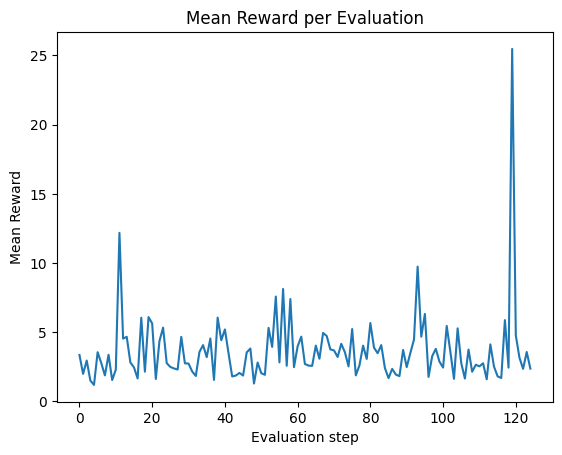

In [108]:
# Load and train

# Load the trained model and ensure the training environment is wrapped with VecNormalize
train_env = DummyVecEnv([lambda: Monitor(gym.make('CustomPongEnv-v0')) for _ in range(4)])
train_env = VecNormalize.load("vecnormalize.pkl", train_env)
train_env.training = True  # Ensure it's in training mode

# Create the evaluation environment and wrap it with VecNormalize
eval_env = DummyVecEnv([lambda: Monitor(gym.make('CustomPongEnv-v0'))])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False)
eval_env.training = False  # Ensure it's not in training mode

# Sync normalization statistics from the training environment to the evaluation environment
eval_env.obs_rms = train_env.obs_rms
eval_env.ret_rms = train_env.ret_rms

# Create the CustomEvalCallback with the evaluation environment
eval_callback = CustomEvalCallback(eval_env, best_model_save_path='./logs/best_model',
                                   log_path='./logs/results', eval_freq=2000,
                                   deterministic=True, render=False)

# Load the pre-trained model
model = PPO.load("ppo_custom_pong_1", env=train_env)

# Resume training the model with the callback
model.learn(total_timesteps=1000000, callback=eval_callback)

# Save the model and the normalization statistics
model.save("ppo_custom_pong_1")
train_env.save("vecnormalize.pkl")

print("Training completed and logs are saved.")

# Plot the mean rewards
plt.plot(eval_callback.mean_rewards)
plt.xlabel('Evaluation step')
plt.ylabel('Mean Reward')
plt.title('Mean Reward per Evaluation')
plt.show()

In [ ]:
# Evaluate the trained model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

Mean reward: 36.81911273412406 +/- 62.40618049660436


In [105]:
# Load the trained model and evaluate
# model = PPO.load("ppo_custom_pong_1")
model = PPO.load("./logs/best_model/best_model")

# Create a new environment for rendering
eval_env = DummyVecEnv([lambda: Monitor(gym.make('CustomPongEnv-v0'))])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False)
eval_env.training = False  # Ensure we're not in training mode to prevent normalization updates
eval_env.norm_reward = False  # Disable reward normalization for evaluation

# Load the normalization statistics
train_env = DummyVecEnv([lambda: Monitor(gym.make('CustomPongEnv-v0'))])
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True)
train_env = VecNormalize.load("vecnormalize.pkl", train_env)

# Sync the observation normalization statistics
eval_env.obs_rms = train_env.obs_rms

# Extract the first environment from the vectorized environment
env = eval_env.envs[0]

# Run a simple loop to demonstrate rendering with the trained model
obs = eval_env.reset()
count = 0

while count < 4:
    action, _states = model.predict(obs, deterministic=True)  # Get action from the trained model
    obs, reward, done, info = eval_env.step(action)
    env.render()
    if done:
      count += 1
      print(eval_env.envs[0].game_state)
      obs = eval_env.reset()

env.close()

  and should_run_async(code)

  logger.deprecation(



serve
hit


  logger.warn(



{'server': 'Player1', 'positions_reversed': True, 'opponent': 'Player1', 'player': 'Player2', 'Player1': {'x': 1185, 'y': 355, 'dy': 0, 'width': 15, 'height': 180, 'colour': 'blue'}, 'Player2': {'x': 0, 'y': 355, 'dy': 0, 'width': 15, 'height': 90, 'colour': 'red'}, 'ball': {'x': 1173, 'y': 445.0, 'dx': 10, 'dy': 10, 'radius': 12, 'speed': 10, 'serve_mode': True, 'score_mode': False, 'score_mode_timeout': 0}, 'stats': {'rally_length': 0, 'serve_speed': 10, 'server': 'Player1'}}
serve
hit
hit
hit
{'server': 'Player1', 'positions_reversed': False, 'opponent': 'Player1', 'player': 'Player2', 'Player1': {'x': 0, 'y': 355, 'dy': 0, 'width': 15, 'height': 180, 'colour': 'blue'}, 'Player2': {'x': 1185, 'y': 355, 'dy': 0, 'width': 15, 'height': 90, 'colour': 'red'}, 'ball': {'x': 27, 'y': 445.0, 'dx': 10, 'dy': 10, 'radius': 12, 'speed': 10, 'serve_mode': True, 'score_mode': False, 'score_mode_timeout': 0}, 'stats': {'rally_length': 0, 'serve_speed': 10, 'server': 'Player1'}}
serve
hit
{'serve

  size = imread(sequence[0]).shape



{'server': 'Player1', 'positions_reversed': False, 'opponent': 'Player1', 'player': 'Player2', 'Player1': {'x': 0, 'y': 355, 'dy': 0, 'width': 15, 'height': 180, 'colour': 'blue'}, 'Player2': {'x': 1185, 'y': 355, 'dy': 0, 'width': 15, 'height': 90, 'colour': 'red'}, 'ball': {'x': 27, 'y': 445.0, 'dx': 10, 'dy': 10, 'radius': 12, 'speed': 10, 'serve_mode': True, 'score_mode': False, 'score_mode_timeout': 0}, 'stats': {'rally_length': 0, 'serve_speed': 10, 'server': 'Player1'}}
Moviepy - Building video ./game_video.mp4.
Moviepy - Writing video ./game_video.mp4



Moviepy - Done !
Moviepy - video ready ./game_video.mp4


In [ ]:
# Load the trained PPO model
model = PPO.load(f"{path}/ppo_custom_pong_{name}.{iteration+1}")

# Extract the PyTorch model's weights
policy_weights = model.policy.state_dict()

# Define the TensorFlow model
class TfPPOPolicy(tf.Module):
    def __init__(self, input_dim, output_dim):
        super(TfPPOPolicy, self).__init__()
        self.fc1 = layers.Dense(64, activation='relu', input_shape=(input_dim,))
        self.fc2 = layers.Dense(64, activation='relu')
        self.action_head = layers.Dense(output_dim)
        self.value_head = layers.Dense(1)

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 8], dtype=tf.float32)])
    def __call__(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        action_logits = self.action_head(x)
        value = self.value_head(x)
        return action_logits, value

    def predict(self, x):
        action_logits, value = self.__call__(x)
        # Apply sigmoid to the buttonPressed logits to constrain between 0 and 1
        buttonPressed = tf.sigmoid(action_logits[:, 0])
        paddleDirection = action_logits[:, 1]
        return buttonPressed, paddleDirection


# Create the TensorFlow model
input_dim = 8  # Your observation space dimension
output_dim = 2  # Number of actions
tf_policy = TfPPOPolicy(input_dim, output_dim)

# Load weights into the TensorFlow model
tf_policy.fc1.build((None, input_dim))
tf_policy.fc1.set_weights([
    policy_weights['mlp_extractor.policy_net.0.weight'].cpu().numpy().T,
    policy_weights['mlp_extractor.policy_net.0.bias'].cpu().numpy()
])

tf_policy.fc2.build((None, 64))
tf_policy.fc2.set_weights([
    policy_weights['mlp_extractor.policy_net.2.weight'].cpu().numpy().T,
    policy_weights['mlp_extractor.policy_net.2.bias'].cpu().numpy()
])

tf_policy.action_head.build((None, 64))
tf_policy.action_head.set_weights([
    policy_weights['action_net.weight'].cpu().numpy().T,
    policy_weights['action_net.bias'].cpu().numpy()
])

tf_policy.value_head.build((None, 64))
tf_policy.value_head.set_weights([
    policy_weights['value_net.weight'].cpu().numpy().T,
    policy_weights['value_net.bias'].cpu().numpy()
])

# Save the wrapped policy as a TensorFlow SavedModel
saved_model_path = "./saved_model"
tf.saved_model.save(tf_policy, saved_model_path)

# Convert the SavedModel to TensorFlow.js format using the command line
# !tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model ./saved_model ./tfjs_model


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
iteration = 4
model = PPO.load(f"{path}/ppo_custom_pong_{name}.{iteration+1}")

# Extract PyTorch model's weights
policy_weights = model.policy.state_dict()

# Define the TensorFlow model
class TfPPOPolicy(tf.Module):
    def __init__(self, input_dim, output_dim):
        super(TfPPOPolicy, self).__init__()
        self.fc1_policy = layers.Dense(64, activation='tanh', name='fc1_policy')
        self.fc2_policy = layers.Dense(64, activation='tanh', name='fc2_policy')
        self.fc1_value = layers.Dense(64, activation='tanh', name='fc1_value')
        self.fc2_value = layers.Dense(64, activation='tanh', name='fc2_value')
        self.action_head = layers.Dense(output_dim, name='action_head')
        self.value_head = layers.Dense(1, name='value_head')

        # Build the layers by running a dummy input through the network
        dummy_input = tf.random.uniform((1, input_dim))
        self.__call__(dummy_input)

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 8], dtype=tf.float32)])
    def __call__(self, x):
        policy_x = self.fc1_policy(x)
        policy_x = self.fc2_policy(policy_x)
        action_logits = self.action_head(policy_x)

        value_x = self.fc1_value(x)
        value_x = self.fc2_value(value_x)
        value = self.value_head(value_x)

        return action_logits, value

    def predict(self, x):
        action_logits, value = self.__call__(x)
        buttonPressed = tf.sigmoid(action_logits[:, 0])
        paddleDirection = action_logits[:, 1]
        return buttonPressed, paddleDirection

# Instantiate the TensorFlow model
input_dim = 8  # Adjust based on your actual input dimension
output_dim = 2  # Adjust based on your actual output dimension
tf_policy = TfPPOPolicy(input_dim, output_dim)

# Helper function to assign weights
def assign_weights(tf_model, torch_weights):
    # Assign policy network weights
    tf_model.fc1_policy.kernel.assign(tf.convert_to_tensor(torch_weights['mlp_extractor.policy_net.0.weight'].t().numpy(), dtype=tf.float32))
    tf_model.fc1_policy.bias.assign(tf.convert_to_tensor(torch_weights['mlp_extractor.policy_net.0.bias'].numpy(), dtype=tf.float32))
    tf_model.fc2_policy.kernel.assign(tf.convert_to_tensor(torch_weights['mlp_extractor.policy_net.2.weight'].t().numpy(), dtype=tf.float32))
    tf_model.fc2_policy.bias.assign(tf.convert_to_tensor(torch_weights['mlp_extractor.policy_net.2.bias'].numpy(), dtype=tf.float32))

    # Assign value network weights
    tf_model.fc1_value.kernel.assign(tf.convert_to_tensor(torch_weights['mlp_extractor.value_net.0.weight'].t().numpy(), dtype=tf.float32))
    tf_model.fc1_value.bias.assign(tf.convert_to_tensor(torch_weights['mlp_extractor.value_net.0.bias'].numpy(), dtype=tf.float32))
    tf_model.fc2_value.kernel.assign(tf.convert_to_tensor(torch_weights['mlp_extractor.value_net.2.weight'].t().numpy(), dtype=tf.float32))
    tf_model.fc2_value.bias.assign(tf.convert_to_tensor(torch_weights['mlp_extractor.value_net.2.bias'].numpy(), dtype=tf.float32))

    # Assign action and value head weights
    tf_model.action_head.kernel.assign(tf.convert_to_tensor(torch_weights['action_net.weight'].t().numpy(), dtype=tf.float32))
    tf_model.action_head.bias.assign(tf.convert_to_tensor(torch_weights['action_net.bias'].numpy(), dtype=tf.float32))
    tf_model.value_head.kernel.assign(tf.convert_to_tensor(torch_weights['value_net.weight'].t().numpy(), dtype=tf.float32))
    tf_model.value_head.bias.assign(tf.convert_to_tensor(torch_weights['value_net.bias'].numpy(), dtype=tf.float32))

# Assign the weights
assign_weights(tf_policy, model.policy.state_dict())

# Get intermediate outputs from the PyTorch model
def get_pytorch_intermediate_outputs(model, input_data):
    with th.no_grad():
        x = input_data
        x1 = model.policy.mlp_extractor.policy_net[0](x)
        x2 = model.policy.mlp_extractor.policy_net[2](x1)
        action_logits = model.policy.action_net(x2)
        value_x1 = model.policy.mlp_extractor.value_net[0](x)
        value_x2 = model.policy.mlp_extractor.value_net[2](value_x1)
        value = model.policy.value_net(value_x2)
    return x1, x2, action_logits, value_x1, value_x2, value

# Get intermediate outputs from the TensorFlow model
def get_tf_intermediate_outputs(model, input_data):
    policy_x1 = model.fc1_policy(input_data)
    policy_x2 = model.fc2_policy(policy_x1)
    action_logits = model.action_head(policy_x2)
    value_x1 = model.fc1_value(input_data)
    value_x2 = model.fc2_value(value_x1)
    value = model.value_head(value_x2)
    return policy_x1, policy_x2, action_logits, value_x1, value_x2, value

# Test the conversion with a small input
test_input = th.rand(1, input_dim)  # Use a fixed test input
torch_policy_x1, torch_policy_x2, torch_action_logits, torch_value_x1, torch_value_x2, torch_value = get_pytorch_intermediate_outputs(model, test_input)

# Ensure the input to TensorFlow is identical
tf_input = tf.convert_to_tensor(test_input.numpy(), dtype=tf.float32)
tf_policy_x1, tf_policy_x2, tf_action_logits, tf_value_x1, tf_value_x2, tf_value = get_tf_intermediate_outputs(tf_policy, tf_input)

# Print intermediate outputs
print("PyTorch policy fc1 output:", torch_policy_x1.detach().numpy())
print("TensorFlow policy fc1 output:", tf_policy_x1.numpy())

print("PyTorch policy fc2 output:", torch_policy_x2.detach().numpy())
print("TensorFlow policy fc2 output:", tf_policy_x2.numpy())

print("PyTorch action logits:", torch_action_logits.detach().numpy())
print("TensorFlow action logits:", tf_action_logits.numpy())

print("PyTorch value fc1 output:", torch_value_x1.detach().numpy())
print("TensorFlow value fc1 output:", tf_value_x1.numpy())

print("PyTorch value fc2 output:", torch_value_x2.detach().numpy())
print("TensorFlow value fc2 output:", tf_value_x2.numpy())

print("PyTorch value:", torch_value.detach().numpy())
print("TensorFlow value:", tf_value.numpy())

saved_model_path = "./saved_model_new"
tf.saved_model.save(tf_policy, saved_model_path)


PyTorch policy fc1 output: [[-0.15904823 -0.0670957   0.10368206  0.30483988  0.01337119 -0.24508096
  -0.3546461  -0.48025256  0.03984199  0.63393235 -0.09844951  0.41337955
  -0.11019313  0.45303807  0.11283946  0.28443953 -0.56069803  0.34210873
   0.23990984  0.22165376  0.20915824 -0.1377928  -0.06990146  0.16214462
  -0.00795686 -0.3767324   0.02442205  0.01465188  0.05508695  0.1515808
   0.09872608  0.12319711 -0.11831853 -0.47226366 -0.24919662  0.0546505
  -0.16687143  0.12732671 -0.2569833  -0.1844132   0.19296348 -0.44674465
   0.30742025  0.02844924  0.28813526 -0.13057217 -0.12696053 -0.05529656
  -0.624382   -0.11825649  0.5915864  -0.21161465  0.24253242  0.25089306
   0.26347867  0.00536796  0.13035037  0.09258169  0.02575868  0.28844428
  -0.4807719   0.38800618 -0.3156076   0.21997526]]
TensorFlow policy fc1 output: [[-0.15772057 -0.06699519  0.10331212  0.29573548  0.0133704  -0.24028914
  -0.34048945 -0.44644582  0.03982091  0.560754   -0.09813269  0.39133838
  -0.

In [ ]:
# Convert the SavedModel to TensorFlow.js format using the command line
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model ./saved_model_new ./tfjs_model

2024-06-04 15:18:50.093334: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [95]:
%pip install pygame
%pip install moviepy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
